In [1]:
"""
The notebook is a simple offline beamformer that can be used to generate
the gain pattern of 1 receiver element within the BEST phased array 
in H and E plane. Each receiver is composed of 16 dipole antennas 
which are combined using an analogue combiner.

Using the simulated gain pattern for each of the 16 dipoles, the gain pattern
for the receiver element can be obtained by summing the 
individual contributions of each dipole. The phase 
difference for each diploe antenna has to be 
taken into account before the summation.

"""

'\nThe notebook is a simple offline beamformer that can be used to generate\nthe gain pattern of 1 receiver element within the BEST phased array \nin H and E plane. Each receiver is composed of 16 dipole antennas \nwhich are combined using an analogue combiner.\n\nUsing the simulated gain pattern for each of the 16 dipoles, the gain pattern\nfor the receiver element can be obtained by summing the \nindividual contributions of each dipole. The phase \ndifference for each diploe antenna has to be \ntaken into account before the summation.\n\n'

In [11]:
import numpy as np
import time
import sys
import os
import pandas as pd

In [3]:
# List of constants
C = 299792458.0 # speed of light
F_C = 408000000 # center frequency
_LAMBDA = C / F_C # wavelength
N_DIPOLES = 16 # number of BEST dipoles to combine
N_CYLINDERS = 1 # Number of BEST cylinders to combine
N_THETA = 257 # Number of data points in the theta plane
N_PHI = 1024  # Number of data points in the phi plane
ELEMENT_ID = 1 # Determine which element within the array to use
NAME = "Combined Gain Pattern"

In [4]:
dx = _LAMBDA / 2 # distance between BEST dipoles
dy = 1 # distance between BEST cylinders

In [5]:
x = np.linspace(0, dx, N_DIPOLES)
y = np.linspace(0, dy, N_CYLINDERS)
xv, yv = np.meshgrid(x, y)

In [9]:
k0 = 2 * np.pi / _LAMBDA

theta = np.radians(np.linspace(0, 90, N_THETA))
phi = np.radians(np.linspace(0, 360, N_PHI))
kx = np.zeros((N_PHI, N_THETA))
ky = np.zeros((N_PHI, N_THETA))

for i in range(N_PHI):
    for j in range(N_THETA):
        kx[i, j] = k0 * np.cos(phi[i]) * np.sin(theta[j])
        ky[i, j] = k0 * np.sin(phi[i]) * np.sin(theta[j])

In [10]:
# Load the elements gain pattern in H and V plane (to be loaded from Eman's simulation)
H = np.ndarray(shape=(N_THETA, N_PHI, N_DIPOLES))
E = np.ndarray(shape=(N_THETA, N_PHI, N_DIPOLES))

In [132]:
h_plane = pd.read_csv('dipoles/mid_dipole_phi_90.txt', header=0, delimiter=r'\s+', skiprows=[1])
e_plane = pd.read_csv('dipoles/mid_dipole_phi_0.txt', header=0, delimiter=r'\s+', skiprows=[1])

h_plane.head()

,Theta[deg.],Phi[deg.],Abs(Gain)[dB],Abs(Theta)[dB],Phase(Theta)[deg.],Abs(Phi)[dB],Phase(Phi)[deg.],Ax.Ratio[dB]
0,-180.0,90.0,-25.15,-36.25,105.282,-25.51,197.333,10.75
1,-179.0,90.0,-25.63,-34.20,195.179,-26.29,198.272,34.57
2,-178.0,90.0,-24.43,-27.39,221.957,-27.49,198.580,13.69
3,-177.0,90.0,-22.08,-23.03,232.850,-29.15,197.756,12.34
4,-176.0,90.0,-19.54,-19.83,239.852,-31.39,194.852,14.88


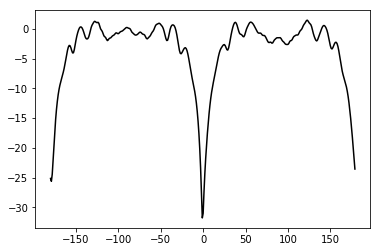

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# h_plane['Theta[rad.]'] = np.radians(h_plane['Theta[deg.]'])
# h_plane['Phi[rad.]'] = np.radians(h_plane['Phi[deg.]'])

# h_plane['X'] = h_plane['Abs(Gain)[dB]'] * np.cos(h_plane['Theta[rad.]']) * np.cos(h_plane['Phi[rad.]'])
# h_plane['Y'] = h_plane['Abs(Gain)[dB]'] * np.cos(h_plane['Theta[rad.]']) * np.sin(h_plane['Phi[rad.]'])
# h_plane['Z'] = h_plane['Abs(Gain)[dB]'] * np.sin(h_plane['Theta[rad.]'])

# e_plane['Theta[rad.]'] = np.radians(e_plane['Theta[deg.]'])
# e_plane['Phi[rad.]'] = np.radians(e_plane['Phi[deg.]'])

# e_plane['X'] = e_plane['Abs(Gain)[dB]'] * np.sin(e_plane['Theta[rad.]']) * np.cos(e_plane['Phi[rad.]'])
# e_plane['Y'] = e_plane['Abs(Gain)[dB]'] * np.sin(e_plane['Theta[rad.]']) * np.sin(e_plane['Phi[rad.]'])
# e_plane['Z'] = e_plane['Abs(Gain)[dB]'] * np.cos(e_plane['Theta[rad.]'])


# ax = fig.gca(projection='3d')
# ax.plot(h_plane['X'], h_plane['Y'], h_plane['Z'], label='H Plane')
# ax.plot(e_plane['X'], e_plane['Y'], e_plane['Z'], label='E Plane')
# ax.legend()



plt.plot(h_plane['Theta[deg.]'], h_plane['Abs(Gain)[dB]'], c= 'k')


In [ ]:
# Loop over all the elements patters to compute average element pattern
for dipole in range(N_DIPOLES):
    # Compute total phase offset
    phase_offset = kx * xv[0, dipole] + ky * yv[0, dipole]
    center_shift = np.exp(-1j * phase_offset)

    # Phase shift the element pattern  (theta, phi, dipole)   
    H[:, :, i] *= center_shift
    E[:, :, i] *= center_shift

    
# Combine the phase-corrected elements pattern into a single beam
combined_H = np.sum(H, axis=2)
combined_E = np.sum(E, axis=2)

In [ ]:
# Visualise the radiation pattern of the combined element